In [22]:
import intake
import healpy as hp
import cmocean
import numpy as np
import xarray as xr
from scipy.optimize import curve_fit

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

import easygems.healpix as egh
import seaborn as sns

In [23]:
Lv = 2.5e6
cp = 1004.
Rd = 287.05
grav = 9.81

data_path = '/home/WUR/janss254/orcestra/data'
data_path_fp = data_path+'/data_fp'

In [24]:
# Linear profile, no fixed shear, and African Easterly Jet model => Use for u?
def linv_aej(z, u0, dudz, ujet, href=4000, hsca=6000):
    u = u0 + dudz*z
    aej = -ujet*(np.cos(np.pi*(z - href)/hsca))**2 # z = href - 0.5*hsca => (href - 0.5*hsca - href) / hsca = -0.5
    aej[z<=href-0.5*hsca] = 0
    aej[z>=href+0.5*hsca] = 0
    return u + aej

# Linear profile, no fixed shear => Use for v
def linv(z, u0, dudz):
    return u0 + dudz*z

# Linear profile with mixed layer, with mixed layer value based on surface value (u0) minus offset => Use for thl
def linml(z, u0, dudz, du0=1.25, zml=500):
    u = np.zeros(z.shape)
    u[z<=zml] = u0 - du0 # Positive offsets are reductions w.r.t surface
    u[z>zml] = u0 - du0 + (z[z>zml] - zml)*dudz
    return u

# Exponential decay with mixed layer, where u0 is set at zml => Use for qt
def exp(z, u0, u_lambda, zml=500):
    u = u0 * np.exp(-(z-zml) / u_lambda)
    if type(u0) == float:
        u[z<=zml] = u0
    elif u0.ndim < 2:
        u[z<=zml] = u0
    elif u0.ndim == 2:
        z  = z .reshape(z.size)
        u0 = u0.reshape(u0.size)
        for i in range(u0.size):
            u[z<=zml,i] = u0[i]
    else:
        print('Dimension of input u0 not supported, mixed layer not added')
    return u

# Relaxation towards a reference profile over a certain height => Use for all profiles
def relax(z, prof_ideal, prof_ref, href=9e3, hsca=3e3):
    # Assumes 1D input
    if prof_ideal.size != prof_ref.size:
        prof_ref = prof_ref.interp(zm=z,kwargs={"fill_value": "extrapolate"})

    du = prof_ideal - prof_ref

    # Subtract difference from the original profile, scaled by a function which goes
    # from 0->1 over a height hsca centered around href
    fac = 0.5 - 0.5*np.cos(np.pi*(z - (href-0.5*hsca))/hsca)
    fac[z<=href-0.5*hsca] = 0
    fac[z>=href+0.5*hsca] = 1

    return prof_ideal - du*fac

In [25]:
# era5 profiles, averaged over a mesoscale box and ~1200 summer days
era5_env_mn = xr.open_dataset('era5_env_mn.nc')

# Surface pressure and surface theta_l
thls = era5_env_mn['sst']*(1e5/era5_env_mn['sp'])**(2./7)
print('Mean ps:', era5_env_mn['sp'].mean().data)
print('Mean thls:', thls.mean().data)   

# fitting height range
zfitmin = 0
zfitmax = 8e3

era5_env_mn_fit = era5_env_mn.sel(zm=slice(zfitmax,zfitmin)).astype('float64')
zfit = era5_env_mn['zm'].sel(zm=slice(zfitmax,zfitmin)).astype('float64')

# fit profiles
[thls,dthldz], pcth = curve_fit(linml,
                                zfit, 
                                era5_env_mn_fit['theta_l'], 
                                p0=[300,0.004])

[qt0,hqt], pcqt = curve_fit(exp,
                            zfit,
                            era5_env_mn_fit['q'],
                            p0=[0.016,1500])

[u0,dudz,ujet], pcu = curve_fit(linv_aej,
                                zfit,
                                era5_env_mn_fit['u'],
                                p0=[-1, 0.00222,6])

[v0,dvdz], pcv = curve_fit(linv,
                           zfit,
                           era5_env_mn_fit['v'],
                           p0=[0,0])

# evaluate profiles
zgrid = np.linspace(20., 12e3, 250) # should be higher, using 12km for plotting

thl = linml(zgrid, thls, dthldz) # FIXME is that the right thls to use for the SST?
qt = exp(zgrid, qt0, hqt)
u = linv_aej(zgrid, u0, dudz, ujet)
v = linv(zgrid, v0, dvdz)

# relax them back to the reference state
qt = relax(zgrid, qt, era5_env_mn['q'])
thl = relax(zgrid, thl, era5_env_mn['theta_l'])
u = relax(zgrid, u, era5_env_mn['u'])
v = relax(zgrid, v, era5_env_mn['v'])

# check that thls>thl[0]
dthls0 = thls.mean().data-thl[0]
print('thls - thl[0]:', dthls0) 

# TODO:
# Settle on horizontal/vertical advection
# Base state for radiation above the TOD   


Mean ps: 101297.63
Mean thls: 299.556058470572
thls - thl[0]: <xarray.DataArray 'theta_l' ()> Size: 8B
array(1.25)
Coordinates:
    level    float64 8B 1.011e+03
    zm       float64 8B 20.0


In [26]:
## Compare with the mean profiles from Phillipe

ds_t_pp = xr.open_dataset(data_path_fp+'/t_vertical_profile_clim_9-15N_23-29W.nc').rename({'d':'t'})
ds_q_pp = xr.open_dataset(data_path_fp+'/q_vertical_profile_clim_9-15N_23-29W.nc').rename({'d':'q'})
ds_u_pp = xr.open_dataset(data_path_fp+'/u_vertical_profile_clim_9-15N_23-29W.nc').rename({'d':'u'})
ds_v_pp = xr.open_dataset(data_path_fp+'/v_vertical_profile_clim_9-15N_23-29W.nc').rename({'d':'v'})
ds_d_pp = xr.open_dataset(data_path_fp+'/d_vertical_profile_clim_9-15N_23-29W.nc')

ds_pp = xr.merge([ds_t_pp, ds_q_pp, ds_u_pp, ds_v_pp, ds_d_pp])

## Move these data to the heights of the finer dataset, and convert t to potential t
ds_pp['theta_l'] = ds_pp['t']*(1e5/ds_pp['lev']/100)**(2./7)
ds_pp['z'] = era5_env_mn['theta_l'].swap_dims({'zm':'level'}).sel(level=ds_pp['lev'])
ds_pp = ds_pp.swap_dims({'lev':'z'})
ds_pp

<xarray.Dataset> Size: 192B
Dimensions:  (z: 4)
Coordinates:
    lev      (z) float32 16B 925.0 850.0 700.0 200.0
    level    (z) int64 32B 925 850 700 200
    zm       (z) float32 16B 794.7 1.523e+03 3.165e+03 1.244e+04
  * z        (z) float64 32B 300.1 305.0 313.4 347.8
Data variables:
    t        (z) float32 16B ...
    q        (z) float32 16B ...
    u        (z) float32 16B ...
    v        (z) float32 16B ...
    d        (z) float32 16B ...
    theta_l  (z) float32 16B 300.0 304.9 313.2 347.4

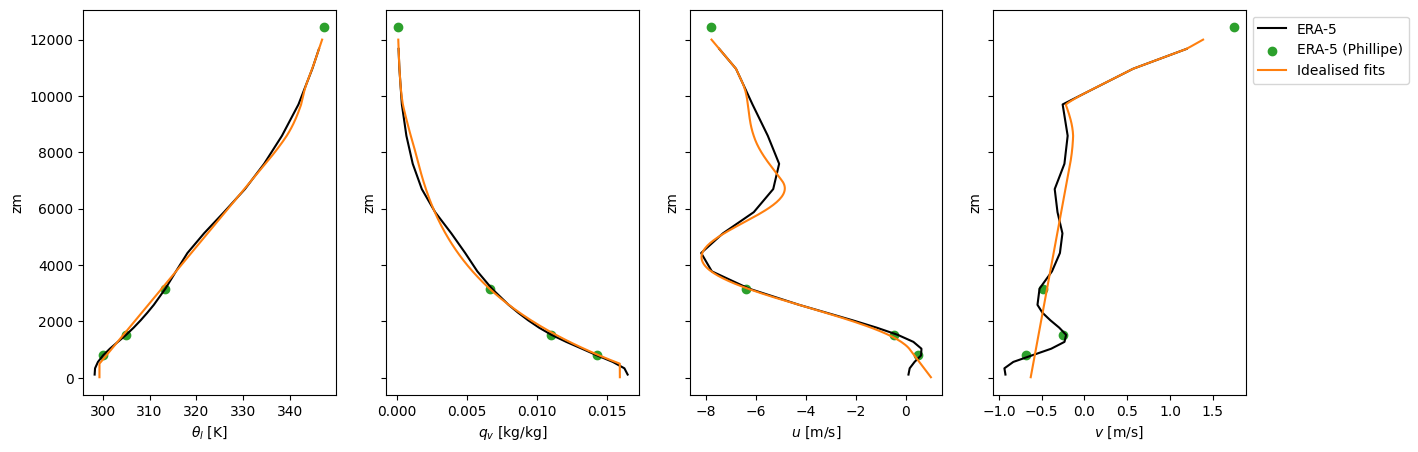

In [27]:
# Put these profiles on plots

cs = ['black', 'C1', 'C2']

era5_env_mn_plt = era5_env_mn.sel(zm=slice(np.max(zgrid),np.min(zgrid)))

fig, axs = plt.subplots(ncols=4,figsize=(15,5),sharey=True)

era5_env_mn_plt['theta_l'].plot(y='zm', ax=axs[0], color=cs[0])
axs[0].scatter(ds_pp['theta_l'], ds_pp['zm'], c=cs[2])
axs[0].plot(thl, zgrid, color=cs[1])
axs[0].set_xlabel(r'$\theta_l$ [K]')

era5_env_mn_plt['q'].plot(y='zm', ax=axs[1], color=cs[0])
axs[1].scatter(ds_pp['q'], ds_pp['zm'], c=cs[2])
axs[1].plot(qt, zgrid, color=cs[1])
axs[1].set_xlabel(r'$q_v$ [kg/kg]')

era5_env_mn_plt['u'].plot(y='zm', ax=axs[2], color=cs[0])
axs[2].scatter(ds_pp['u'], ds_pp['zm'], c=cs[2])
axs[2].plot(u, zgrid, color=cs[1])
axs[2].set_xlabel(r'$u$ [m/s]')

era5_env_mn_plt['v'].plot(y='zm', ax=axs[3], color=cs[0], label='ERA-5')
axs[3].scatter(ds_pp['v'], ds_pp['zm'], c=cs[2], label='ERA-5 (Phillipe)')
axs[3].plot(v, zgrid, color=cs[1], label='Idealised fits')
axs[3].set_xlabel(r'$v$ [m/s]')

axs[3].legend(bbox_to_anchor=(1,1), loc='best')

plt.savefig('prof-test.pdf',bbox_inches='tight')